***Import all required libraries***

In [1]:
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter
import cv2
import matplotlib.pyplot as plt

In [2]:
data_dir = '../input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision/Data Combined'

In [3]:
categories = os.listdir(data_dir)

Let's see what the first image looks like.

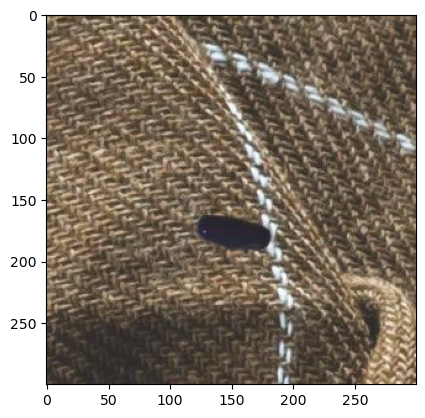

In [4]:
for category in categories: 
    path = os.path.join(data_dir,category) 
    for img in os.listdir(path): 
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show() 
        break
    break

Resize images to reduce network training time.

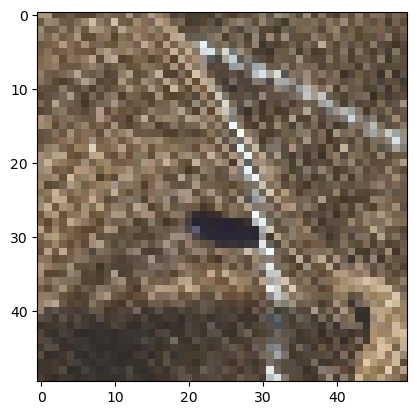

In [5]:
IMG_SIZE = 50
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [6]:
training_data = []
from tqdm import tqdm
def create_training_data():
    for category in categories: 
        path = os.path.join(data_dir,category)
        class_num = categories.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img))  
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
                training_data.append([new_array, class_num])  
            except Exception as e: 
                pass

Loading all data.

In [7]:
create_training_data()

100%|██████████| 1000/1000 [00:04<00:00, 229.41it/s]


Distribution of data by categories.

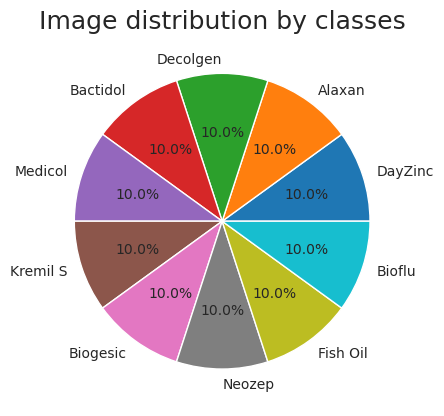

In [8]:
categories_dict = {}
for i in range(10):
    categories_dict[i] = categories[i]
values = np.array(training_data, dtype=object)[:, 1]
counter = Counter(values)
data = pd.DataFrame(data={'Values': counter.values(), 'Category' : categories_dict.values()})

sns.set_style("darkgrid")
plt.pie(data['Values'], labels=data['Category'], autopct='%1.1f%%')
plt.title('Image distribution by classes', size=18)
plt.show()

In [9]:
random.shuffle(training_data)

In [10]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Data preprocessing.

In [12]:
X_train = X_train / 255
X_test = X_test / 255
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

Creation of convolution neural network architecture.

In [13]:
model = keras.Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(50, 50, 3)),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10,  activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 64)        3

In [15]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
epochs = 15
his = model.fit(X_train, y_train_cat, batch_size=32, epochs=epochs, validation_split=0.2)

Epoch 1/15
200/200 [==============================] - 54s 257ms/step - loss: 2.1685 - accuracy: 0.1698 - val_loss: 2.3502 - val_accuracy: 0.1006
Epoch 2/15
200/200 [==============================] - 51s 254ms/step - loss: 1.7206 - accuracy: 0.3373 - val_loss: 1.8587 - val_accuracy: 0.3212
Epoch 3/15
200/200 [==============================] - 51s 257ms/step - loss: 1.1614 - accuracy: 0.5684 - val_loss: 1.1552 - val_accuracy: 0.5781
Epoch 4/15
200/200 [==============================] - 51s 256ms/step - loss: 0.7597 - accuracy: 0.7333 - val_loss: 0.7768 - val_accuracy: 0.7675
Epoch 5/15
200/200 [==============================] - 51s 255ms/step - loss: 0.5061 - accuracy: 0.8234 - val_loss: 0.6201 - val_accuracy: 0.7800
Epoch 6/15
200/200 [==============================] - 51s 256ms/step - loss: 0.3895 - accuracy: 0.8645 - val_loss: 0.4969 - val_accuracy: 0.8363
Epoch 7/15
200/200 [==============================] - 51s 254ms/step - loss: 0.2592 - accuracy: 0.9128 - val_loss: 0.4196 - val_ac

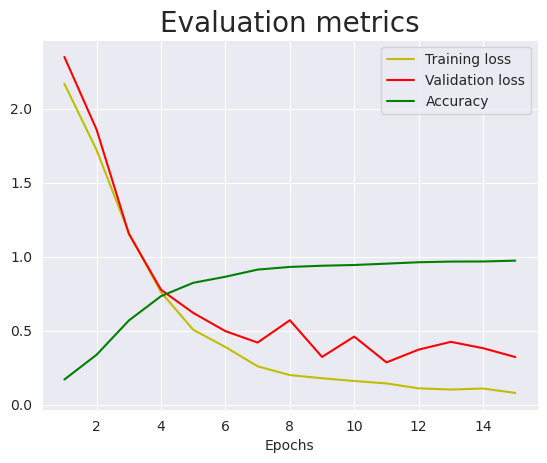

In [17]:
loss = his.history['loss']
val_loss = his.history['val_loss']
accuracy = his.history['accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, accuracy, 'g', label='Accuracy')
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [18]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)

63/63 [==============================] - 3s 53ms/step


In [19]:
print ("Accuracy = ", metrics.accuracy_score(y_test, predictions))

Accuracy =  0.907


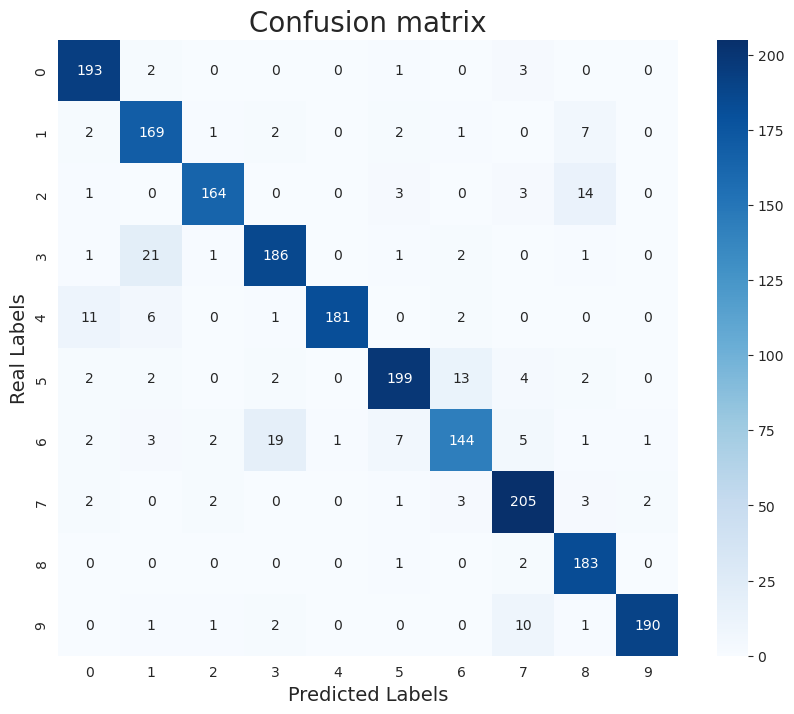

In [20]:
cm = confusion_matrix(y_test, predictions)

ax = plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Real Labels', size=14)
plt.show()

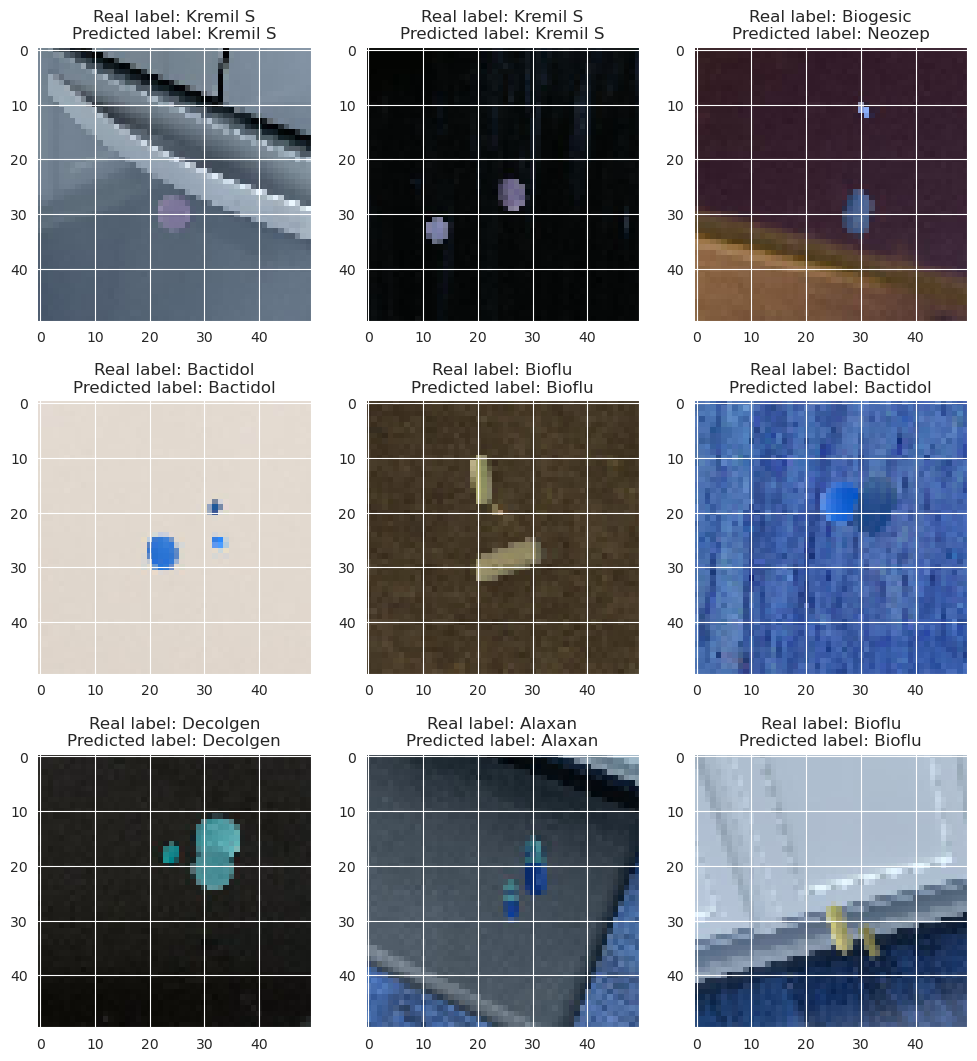

In [21]:
plt.figure(figsize=(12,13))
for i in range(9):
    j = random.randint(0, X_test.shape[0] - 1)
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[j], interpolation='nearest')
    plt.title('Real label: ' + categories_dict[y_test[j]] + '\n' + 'Predicted label: ' + categories_dict[predictions[j]])